In [23]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


In [25]:
image_path = r"D:/Pythun projexx/CaptionGenDS/Images"
data = pd.read_csv(r"D:/Pythun projexx/CaptionGenDS/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [27]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x:x.lower())
    data['caption'] = data['caption'].apply(lambda x:x.replace(r"[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x:x.replace(r"\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    
    return data
    
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [35]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint


model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience=5, verbose =1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose = 1, factor=0.2, min_lr=0.00000001)

history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint,earlystopping,learning_rate_reduction]
)

C:\Users\Days\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Days\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 5.7152
Epoch 1: val_loss improved from inf to 4.29116, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 274s 504ms/step - loss: 5.7140 - val_loss: 4.2912 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 4.3471
Epoch 2: val_loss improved from 4.29116 to 3.96767, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 272s 506ms/step - loss: 4.3470 - val_loss: 3.9677 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 4.0216
Epoch 3: val_loss improved from 3.96767 to 3.82653, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 274s 510ms/step - loss: 4.0216 - val_loss: 3.8265 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 3.8453
Epoch 4: val_loss improved from 3.82653 to 3.71764, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 275s 512ms/step - loss: 3.8453 - val_loss: 3.7176 - learning_rate: 0.0

In [53]:
import pickle

with open("tokenizer.pkl","wb") as f:
    pickle.dump(tokenizer, f)

fe.save("feature_extractor.keras")

In [115]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras. preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

model_path = "D:/Pythun projexx/CaptionGenDS/Dump/model.keras"
tokenizer_path = "D:/Pythun projexx/CaptionGenDS/Dump/tokenizer.pkl"
feature_extractor_path = "D:/Pythun projexx/CaptionGenDS/Dump/feature_extractor.keras"

def GenCaption(image_path, model_path, tokenizer_path, features_extractor_path, max_length=34, img_size=224):
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    tokenizer = pickle.load(open("tokenizer.pkl",'rb'))
    img = load_img(image_path, target_size=(img_size,img_size))
    img = img_to_array(img)/255
    img = np.expand_dims(img,axis=0)
    image_feature = feature_extractor.predict(img, verbose=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_feature, sequence])
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq':
            break
    caption = in_text.replace('startseq','').replace('endseq','').strip()

    img = load_img(image_path, target_size=(img_size,img_size))
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='black')
    plt.show()

In [117]:
#FINALLY

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


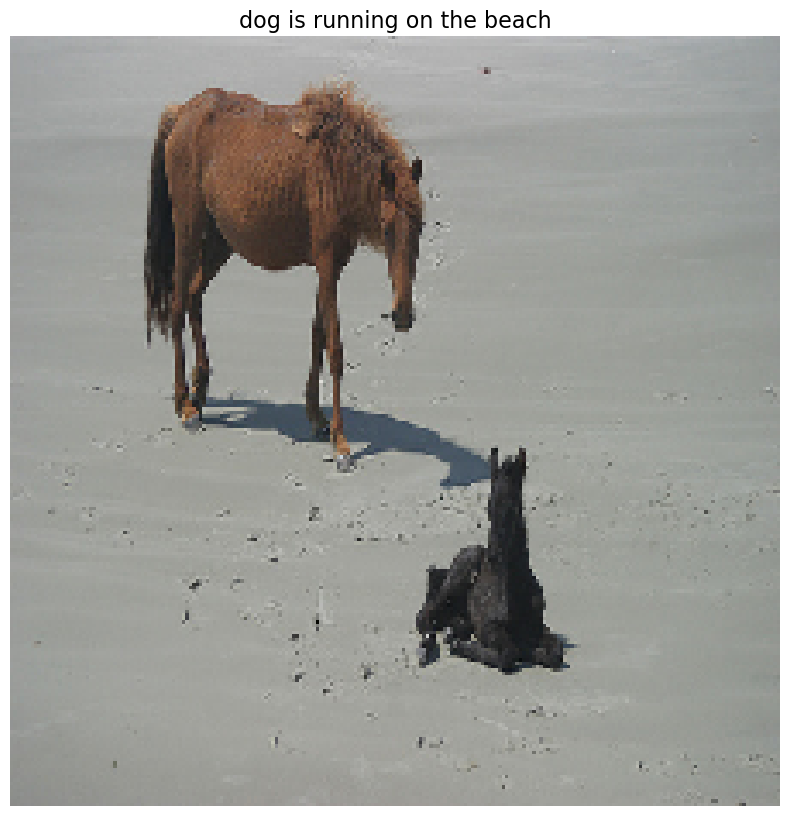

In [119]:
image_path = "D:/Pythun projexx/CaptionGenDS/Images/124195430_d14028660f.jpg"
GenCaption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
#that is not a dog

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


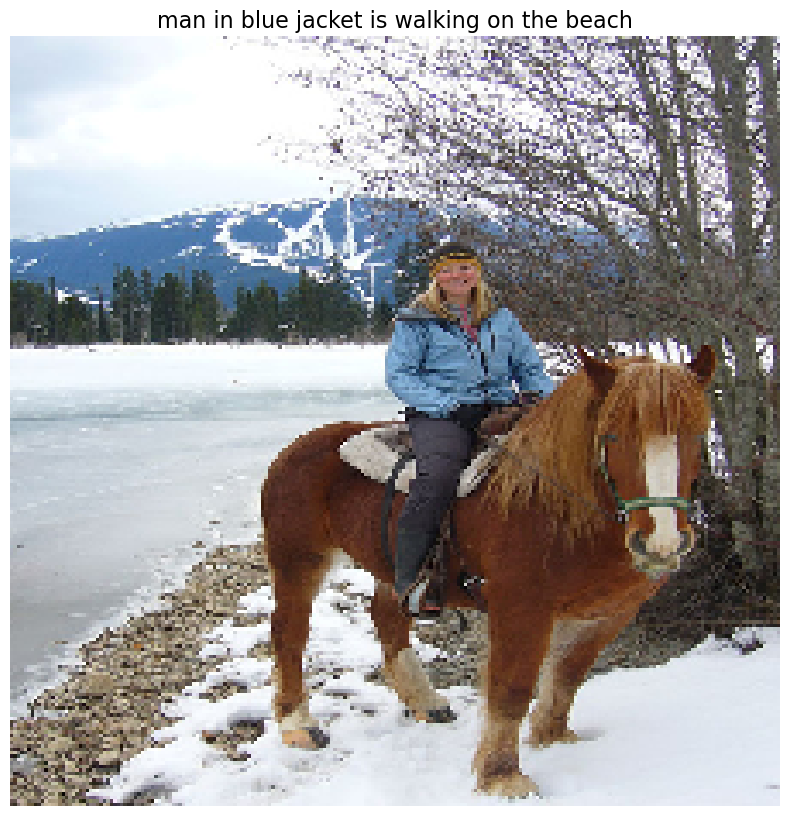

In [99]:
image_path = "D:/Pythun projexx/CaptionGenDS/Images/109202756_b97fcdc62c.jpg"
GenCaption(image_path, model_path, tokenizer_path, feature_extractor_path)